In [1]:
from iminuit import Minuit
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import scipy
from scipy.optimize import minimize, rosen, rosen_der
from scipy.special import factorial
import scipy.integrate as integrate
from scipy.integrate import quad
from itertools import starmap
from scipy import optimize
import corner
import time
from mpl_toolkits import mplot3d
import healpy as hp
from scipy import nan
import dark_matter_jfactors as dmj
import math
import random
import importlib
from pymultinest.solve import solve
import pymultinest
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import scipy.interpolate
import json
from os import walk
import re

In [2]:
filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']
evermore_shifted = np.asarray([
    [33, 21, 49],
    [154, 112, 82],
    [241, 149, 91],
    [142, 52, 38],
    [33, 21, 49],
])/256

#exposure_time = 4.1e6 #.13 years 47 days
#exposure_time = 4.1e8 #13 years
#exposure_time = 4.1e9 #130 years
#exposure_time = 4.1e11 #13000 years
exposure_time = 4.1e16 #1 billion years
#exposure_time = 3.154e10


In [3]:


def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value="extrapolate")
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def get_all_egb_data(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
    return middle_bin, bin_width, egb_intensity

def get_all_egb(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
        

    log_interp = log_interp1d(middle_bin, egb_intensity/bin_width, kind='linear')
    
    '''
    print(egb_intensity[2]/bin_width[2]*deltae[6])
    print(energies[6])
    x_trapz = np.logspace(np.log10(np.nanmin(energies)), np.log10(np.nanmax(energies)), num = 100)
    plt.scatter(middle_bin, egb_intensity/bin_width)
    plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
    plt.scatter(energies[6], log_interp(energies[6]), color = 'green')
    plt.yscale('log')
    plt.xscale('log')
    '''
    
    counts = []
    #only want energies from 3 onward (about lowest at 80 MeV)
    for x in range(3, len(energies)):
        highest_val = energies[x]+deltae[x]
        lowest_val = energies[x]-deltae[x]
        x_trapz = np.logspace(np.log10(lowest_val), np.log10(highest_val), num = 400)
        #counts.append(log_interp(energies[x])*deltae[x])
        total_counts = np.trapz(log_interp(x_trapz), x = x_trapz)
        
        #print('total counts: {}'.format(total_counts))
        '''
        plt.scatter(middle_bin, egb_intensity/bin_width)
        plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
        plt.scatter(energies[x], total_counts)
        
        plt.yscale('log')
        plt.xscale('log')
        asdfads
        '''
        counts.append(total_counts)  
    return counts #returns counts per cm^2 per sec per str


In [4]:
def readfile(filename):
    """
    A simple function to read the maps of a given number n and given filename.
    """
    file_to_read = fits.open(filename)
    return file_to_read

def reshape_file(hdu, n, inner20 = True):
    """
    Reshapes the data to be in the size we want
    """
    
    if inner20:
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        inner_20_pos = np.where(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
        inner_20_neg = np.where(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
        testbin = list(hdu[n].data[inner_20_pos])+list(hdu[n].data[inner_20_neg])
        
        #might need this for plotting, not sure
        #data4 = hdu[n].data
        #test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #testbin = np.reshape(test20, (128*3, 1536//3))

    else:
        """
        testbin = np.reshape(hdu[n].data, (128*3, 1536//3))
        
        """
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        
        inner_20_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
        inner_20_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
        inner_20 = np.logical_and(inner_20_pos, inner_20_neg)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #print(sum(~np.isnan(test20)))
        testbin = np.reshape(test20, (128*3, 1536//3))
        
    return testbin

def get_energy_index(E_desired, hdu):
    energy_hdu = np.concatenate(hdu[38].data, axis = 0)
    idx = find_nearest(energy_hdu, E_desired)
    return idx
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    

In [5]:
def subtract(n):
    ##Template for 1 GeV and 10 GeV
    icsa = readfile(filelist[n])
    
    idx1 = get_energy_index(1*1e3, icsa)
    idx10 = get_energy_index(10*1e3, icsa)
    
    array1 = reshape_file(icsa, idx1, inner20 = False)
    array10 = reshape_file(icsa, idx10, inner20 = False)
    
    ##Sum up idx1 and idx 10, make them equal in sum
    sum1 = np.nansum(array1)
    sum10 = np.nansum(array10)
    array10_adjusted = (array10*sum1/sum10)
    subtract110 = np.abs(array1-array10_adjusted)/array1
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(subtract110)
    fig.colorbar(image, ax=ax, anchor=(0, 0.3), shrink=0.7)
    plt.title(str(filelist[n]))
    
    return

In [6]:


#n = 4 for ICSA, n = 2 for pi0
def psf_smoothing(n, energyidx, inner20psf = False):
    icsa = readfile(filelist[n])

    inner20psf = False
    
    data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at 50 MeV
    

    
    #data50_convolved = gaussian_filter(data50, sigma=0) #PSF off
    data50_convolved = np.copy(data50)
    
    
    hdu = readfile(filelist[n])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    
    data50_convolved = data50_convolved.flatten()

    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    inner_20_pos = np.where(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
    inner_20_neg = np.where(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
    inner_20_pos_forsum = np.argwhere(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
    inner_20_neg_forsum = np.argwhere(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
    inner_20_true_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
    inner_20_true_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
    inner_20 = np.logical_and(inner_20_true_pos, inner_20_true_neg)
    
    initsum = np.nansum(list(data50.flatten()[inner_20_pos_forsum]) + list(data50.flatten()[inner_20_neg_forsum]))
    
    data50_convolved[inner_20] = np.nan
    plotimage = np.reshape(data50_convolved, (128*3, 1536//3))
    #plt.imshow(np.log10(plotimage))
    #plt.show()
    #plt.close()
    
    testbin = list(data50_convolved[inner_20_pos])+list(data50_convolved[inner_20_neg])
    finsum = np.nansum(testbin)

    return np.array(testbin)*initsum/finsum

def psf_smoothing_DM(energyidx, crosssec = 2.2e-26, anal_data = False, mass_dm = 100):
    energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[energyidx]
    bins_in_lin = np.log10(energybin)
    deltae = get_deltaE(energyidx)
    
    highe = (energybin+deltae)/1e3
    lowe = (energybin-deltae)/1e3
    
    hdu = readfile(filelist[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    inner_20_pos = np.where(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
    inner_20_neg = np.where(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
    inner_20_pos_forsum = np.argwhere(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
    inner_20_neg_forsum = np.argwhere(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
    inner_20_true_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
    inner_20_true_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
    inner_20 = np.logical_and(inner_20_true_pos, inner_20_true_neg)
    
    
    #need to make sure the initsum is *only within the inner 20 degrees, same for finsum
    data50 = dmj.get_dNdE(highe, lowe, sigmav = crosssec, analyze_data = anal_data, massx = mass_dm)[1] #photons per cm^2 per sec per str per MeV
    

    
    initsum = np.nansum(list(data50.flatten()[inner_20_pos_forsum]) + list(data50.flatten()[inner_20_neg_forsum]))
    data50_convolved = np.copy(data50)
    #data50_convolved = gaussian_filter(data50, sigma=0) #psf off
    data50_convolved = data50_convolved.flatten()
    data50_convolved[inner_20] = np.nan
    plotimage = np.reshape(data50_convolved, (128*3, 1536//3))
    #plt.imshow(np.log10(plotimage))
    #plt.show()
    #plt.close()


    testbin = list(data50_convolved[inner_20_pos])+list(data50_convolved[inner_20_neg])
    finsum = np.nansum(testbin) #photons per cm^2 per sec per str per MeV
    
    return np.array(testbin)*initsum/finsum

def poisson_dist(n, energyidx, cross_section =2.2e-26, dm = False, analyze_data = False, dm_mass = 100, egb = False, counts = 0):   
    '''
    Performs a PSF smoothing of the array, before converting it into photons per pixel
    
    '''
    deltaE = get_deltaE(energyidx)
    if dm:
        convolved_data = psf_smoothing_DM(energyidx, cross_section, anal_data = analyze_data, mass_dm = dm_mass)/deltaE
    elif egb:
        convolved_data_init = np.empty(5910)
        convolved_data_init.fill(1)
        convolved_data = convolved_data_init*counts #in units of photons per cm^2 per mev per str per sec
    else:
        convolved_data = psf_smoothing(n, energyidx, cross_section) #data in units of photons cm^-2 MeV^-1 str^-1
    deltaomega = 4*np.pi/196608 #divide by num of pixels
    n_gamma = np.array(convolved_data)*deltaE*exposure_time*8500*deltaomega*.2 #13 years*.85meters^2, units of photons per pixel
    
    return n_gamma

def get_deltaE(n):
    energybins = np.concatenate(readfile(filelist[0])[38].data, axis = 0)
    bins_in_lin = np.log10(energybins)[n]
    spacing = 0.05691431
    
    high_bin = 10**(bins_in_lin + spacing)
    low_bin = 10**(bins_in_lin - spacing)
    
    deltaE = np.abs(high_bin - low_bin)
    #print('delta E: {}'.format(deltaE))
    
    return deltaE

def get_image(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(data)
    fig.colorbar(image, ax=ax, anchor=(0, 0.3), shrink=0.7)
    return

def simulated_data(energyidx, templates):
    
    '''
    Use PSF smoothed data to create a random poisson draw to obtain simulated data
    '''
    
    
    n_gammatot = 0
    for i in range(0, len(templates)):
        n_gammatot += templates[i]
    len_of_rand = len(n_gammatot)
    simdata = np.zeros(len_of_rand)
    randdata = np.random.rand(len_of_rand)
    
    for i in range(0, len_of_rand):
        #print(n_gammatot[i])
        if n_gammatot[i]<.01:
            if n_gammatot[i] < randdata[i]:
                simdata[i] = 0
            else:
                simdata[i] = 1
        else:
            simdata[i] = np.random.poisson(lam = n_gammatot[i])
    #print('simdata just 20: ', np.nansum(simdata))
    
    return simdata

def minimize_likelihood(energyidx, cross_sec = 2.2e-26, massdm = 100):
    pi = poisson_dist(2, energyidx)
    ics = poisson_dist(4, energyidx)   
    brem = poisson_dist(0, energyidx)

    darkm = poisson_dist(np.nan, energyidx, cross_section = cross_sec, dm = True, dm_mass = massdm)

    k = simulated_data(energyidx, [pi, ics, brem])#remove DM for accurate
    #print(np.nanmean(lamb))
    #asdfasd
    
    #Need to minimize for lamb < 50 and lamb > 50
    
    bnds = ((0, np.inf), (0, np.inf), (0, np.inf), (1e-30, np.inf))
    result = minimize(likelihood, (1, 1, 1, 1), args = (k, pi, ics, brem, darkm), bounds = bnds)
    min_likelihood = result.x
    chi2 = result.fun
    #print(result)

    return min_likelihood


def likelihood(constants, k, pi, ics, brem, dm):
    """
    Gets the Total Likelihoods from the Gaussian Regime and the Poisson Regime
    Once each has been calculated, multiplies values together for final likelihood
    """
    
    likelihood_poiss = likelihood_poisson(constants, k, pi, ics, brem, dm)
    #print('likelihood: {}'.format(likelihood_poiss)) 
    return likelihood_poiss

def merge(list1, list2):
      
    merged_list = tuple(zip(list1, list2)) 
    return merged_list

def likelihood_gaussian(constants, lamb, pi, ics):
    sigma = np.sqrt(constants[0]*pi+constants[1]*ics)
    mu = lamb
    rng = 0.5
    
    #flatten arrays
    sigma_flat = sigma.flatten()
    mu_flat = mu.flatten()
    length_flattened = len(mu_flat)
    #get arrays in sigma, mu tuple format
    ms_tuples = list(merge(mu_flat, sigma_flat))
    ms = np.array(ms_tuples, dtype = 'f,f')
    lower_bound_arr = mu_flat - rng
    upper_bound_arr = mu_flat + rng
    
    args = np.concatenate((np.full((length_flattened, 1), prob_func), lower_bound_arr.reshape((length_flattened, 1)), upper_bound_arr.reshape((length_flattened, 1)), ms.reshape((length_flattened, 1))), axis = 1)
    
    #log likelihood
    prob = list(starmap(lambda a, b, c, d: quad(a, b, c, d)[0], args))

    #reshape for testing
    l = np.sum(np.log(prob))
    likely = -2*l
    
    return likely
    
def prob_func(x, mu, sigma):
    probdens = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2*((x-sigma**2)/sigma)**2)
    return probdens

#def likelihood_poisson(a0):
def likelihood_poisson(a0, a1, a2, a3, a4):
    lamb = a0*pitest+a1*icstest+a2*bremtest+a3*darkmtest+a4*egbtest
    #lamb = a0*egbtest
    
    #print(a0, a1, a2, a3)
    #print(lamb)

    #lamb = constants[0]*pitest+constants[1]*icstest+constants[2]*bremtest+constants[3]*dmtest
    
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    #print(fprob)
    return -2*np.nansum(fprob)

def likelihood_poisson_three(a0, a1, a2):
    lamb = a0*pitest+a1*icstest+a2*bremtest
    #lamb = a0*egbtest
    
    #print(a0, a1, a2, a3)
    #print(lamb)

    #lamb = constants[0]*pitest+constants[1]*icstest+constants[2]*bremtest+constants[3]*dmtest
    
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    #print(fprob)
    return -2*np.nansum(fprob)

def get_curves(n, energyidx, inner20psf = True):
    icsa = readfile(filelist[n])
    data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at energyidx MeV
    delt = get_deltaE(energyidx)
    return np.asarray(data50)*exposure_time*8500*.2*delt #13 years * .85 m^2 * .2, return in photons /str
    
def get_normalizations_spectrum(deltaE, cross_sec = 2.2e-26, dm_mass = 100):
    
    range_templates = [2, 4, 0] #pi, ics, brem
    e = readfile(filelist[0])[38].data
    energies = np.array(list(e)).T[0]
    templates = []
    temp = []
    deltaomega = 4*np.pi/196608 #i think this should maybe still be total bins in whole image pre-20?

    
    for n in range_templates:
        temp = []
        for index in range(3, len(energies)):
            temp.append(np.nansum(get_curves(n, index))) #units of photons per str
        templates.append(np.asarray(temp)*deltaomega) #gets counts per bin
    

    #dark matter template
    
    dm_temp = []
    dm_templates_tot = []
    for index in range(3, len(energies)):
        energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[index]
        bins_in_lin = np.log10(energybin)
        deltae = get_deltaE(index)
    
        highe = (energybin+deltae)/1e3
        lowe = (energybin-deltae)/1e3
        data50 = dmj.get_dNdE(highe, lowe, sigmav = cross_sec, massx = dm_mass, for_normals = True)[1] #units of photons cm^-2 str^-1 per sec not per MeV?
        #need to cut this to be inner 20 degrees
        
        
        #dm_temp.append(np.nansum(data50))
        dm_temp.append(np.nansum(data50)*exposure_time*8500) #13 years * .85 m^2 * .2, return in photons/str
    dm_templates_tot.append(np.asarray(dm_temp)*deltaomega) #photons per pixel?
    #print(np.nansum(dm_templates_tot[0]))

    #EGB template
    egb_templates = np.array(get_all_egb(energies, deltaE)) #units of counts per cm^2 per sec per str
    egb_temp_fin = egb_templates*8500*exposure_time*deltaomega #counts per bin
    
    
    #return range_templates, energies, [np.array(templates[0])*.2, np.array(templates[1])*.2, np.array(templates[2])*.2]
    return range_templates, energies, [np.array(templates[0])*.2, np.array(templates[1])*.2, np.array(templates[2])*.2, np.array(dm_templates_tot)*.2, np.array(egb_temp_fin)*.2] #counts per pixel
    
    
def get_normalized(energyidx, normals, template_val, energies):
    '''
    Normalizes the ROI based on the shape the spectrums should have
    
    
    Do not need to use this, as long as you stay consistent across all Fermi data
    for the exposure time and collecting area
    
    '''
    
    poisson_pi = poisson_dist(template_val, int(energyidx)) #units of photons per pixel
    init_sum_pi = np.nansum(poisson_pi)
    #print(np.nansum(init_sum_pi))
    if template_val == 2:
        normval = 0
    if template_val == 4:
        normval = 1
    if template_val == 0:
        normval = 2
    print('normval for pi at 0: {}'.format(normals[normval][energyidx])) 
    print('delta E at 0: {}'.format(get_deltaE(energyidx)))
    normal_pi = normals[normval][energyidx]*get_deltaE(energyidx)
    pitest = poisson_pi*normal_pi/init_sum_pi
    print('normalization: {}'.format(np.nansum(pitest)))
    #print(np.nansum(pitest))
    
    #print('----------------------')
    
    return pitest
    

In [7]:


def get_darksusy_counts():
    x = np.loadtxt('yield_DS_keith100.dat', dtype=str).T
    energies = x[1].astype(np.float)*1e3
    yieldperann = x[2].astype(np.float)/1e3 #convert from per GeV to per MeV
    energybins = np.concatenate(readfile(filelist[0])[38].data, axis = 0)
    
    counts = []
    delta = []
    for n in range(0, 38):
        
        bins_in_lin = energybins[n]
        deltae = get_deltaE(n)
    
        highe = (bins_in_lin+deltae)
        lowe = (bins_in_lin-deltae)
        
        good_energies = np.where((energies <=highe) & (energies >= lowe))
        
        final_integral = np.trapz(yieldperann[good_energies], x = energies[good_energies])

        counts.append(final_integral)
        delta.append(deltae)
    return np.array(counts), np.array(delta)



In [14]:
#testing the calculated likelihood

def likelihood_poisson_three(a0, a1, a2):
    lamb = a0*pitest+a1*icstest+a2*bremtest
    #lamb = a0*egbtest
    
    #print(a0, a1, a2, a3)
    #print(lamb)

    #lamb = constants[0]*pitest+constants[1]*icstest+constants[2]*bremtest+constants[3]*dmtest
    
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    #print(fprob)
    return -2*np.nansum(fprob)

def likelihood_poisson_multinest(cube, pitest, icstest, bremtest, ktest):
    #a0 = 10**cube[0]
    a0 = 10**cube[0]
    a1 = 10**cube[1]
    a2 = 10**cube[2]
    lamb = a0*pitest+a1*icstest+a2*bremtest
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    return 2*np.sum(fprob) #perhaps add negative back, perhaps add 2 back?

energyidx = 15

a0 = 10**0.19490610325162125
a1 = 10**--0.22037558699351506
a2 = 10**--0.22037558699351506

print(a0, a1, a2)

pitest = poisson_dist(2, int(energyidx))
icstest = poisson_dist(4, int(energyidx))
bremtest = poisson_dist(0, int(energyidx))
ktest = simulated_data(int(energyidx), [pitest, icstest, bremtest])
cube = [np.log10(a0), np.log10(a1), np.log10(a2)]



print(likelihood_poisson_three(a0, a1, a2))
print(likelihood_poisson_multinest(cube, pitest, icstest, bremtest, ktest))



1.56641236691252 1.6610227738612353 1.6610227738612353
10638335569373.719
-10638335569373.719


In [8]:
#start by testing egb I suppose

importlib.reload(dmj)
#gets darksusy counts for a specific dark matter mass
counts, deltae = get_darksusy_counts()
#be sure to change the dm mass
temps, energies, normals = get_normalizations_spectrum(deltae, cross_sec = 2.2e-26)


mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100
mass of dark matter: 100


In [9]:
e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])

In [28]:
crosssec = 2.2e-26
#EGB getting now, first get all the counts at each energy bin
egb_counts = get_all_egb(energies, deltae)/deltae_cut #units of counts per cm^2 per sec per str per MeV
counting = 0
points = []
errors = []

init_guess = 0.9
for energyidx in range(3, len(energies)):
    print(energyidx, energies[energyidx])
    pitest = poisson_dist(2, int(energyidx))
    icstest = poisson_dist(4, int(energyidx))
    bremtest = poisson_dist(0, int(energyidx))
    darkmtest = poisson_dist(np.nan, int(energyidx), dm = True, cross_section =crosssec)
    darkmtest[np.isnan(darkmtest)] = 0
    egbtest = poisson_dist(np.nan, int(energyidx), egb = True, counts = egb_counts[counting])
    ktest = simulated_data(int(energyidx), [pitest, icstest, bremtest, darkmtest, egbtest])
    m = Minuit(likelihood_poisson, a0=init_guess, a1 = init_guess, a2 = init_guess, a3 = init_guess, a4 = init_guess)
    m.limits = [(0, np.inf), (0, np.inf), (0, np.inf), (1e-20, np.inf), (1e-20, np.inf)]
    m.migrad()
    m.hesse()
    print(m.values)
    print(likelihood_poisson(m.values[0], m.values[1], m.values[2], m.values[3], m.values[4]))
    print('----------')
    if likelihood_poisson(m.values[0], m.values[1], m.values[2], m.values[3], m.values[4]) == 0:
        points.append(0)
        errors.append(0)
    else:
        points.append(m.values)
        errors.append(m.errors)
print(points)
print('------------------')


3 109.7629710930695
mass of dark matter: 100
<ValueView a0=1.0000106095191974 a1=0.9999998964140608 a2=0.9999959962122862 a3=0.4554766046003125 a4=1.0000002039281588>
170722.17462158203
----------
4 142.65416981671697
mass of dark matter: 100
<ValueView a0=0.9999952398817711 a1=1.000000509097502 a2=1.0000023233262856 a3=0.7578700532793201 a4=0.9999998208483387>
170404.62908935547
----------
5 185.40143331981702
mass of dark matter: 100
<ValueView a0=1.0000016115317272 a1=1.0000001673450796 a2=0.9999985384925227 a3=0.9731816666309308 a4=1.0000000990933215>
170661.24658203125
----------
6 240.95819646356009
mass of dark matter: 100
<ValueView a0=1.000002485680909 a1=0.9999995052047581 a2=0.9999982663698592 a3=1.016719962677643 a4=1.0000000955414219>
170837.2446899414
----------
7 313.1629103579625
mass of dark matter: 100
<ValueView a0=1.0000011226494836 a1=0.999999446083355 a2=0.9999990354532455 a3=0.9344383316040159 a4=1.0000001425294052>
171422.26501464844
----------
8 407.00424332193

Get error bar plotting
do one at a time, with a 10 year exposure
Try minuit again

In [46]:
print(len(points))

35


In [23]:
points0 = [] #pi
points1 = [] #ics
points2 = [] #bremm
points3 = [] #dm
points4 = [] #egb


for i in range(0, len(points)):
    points0.append(points[i][0])
    points1.append(points[i][1])
    points2.append(points[i][2])
    points3.append(points[i][3])
    points4.append(points[i][4])
    

In [24]:
def reverse_norm(arr, norm, deltae, egb = False):
    adjusted_arr = np.array(arr)*np.array(norm)
    counts = adjusted_arr*196608 #counts
    per = counts/(exposure_time*8500*.2) #counts divided by 13 years in seconds /.85m^2/.2
    egb = False
    if egb:
        fin = per/4/np.pi/energies[3:]
    else:
        fin = per/4/np.pi/deltae
    return fin #counts per MeV per sec per str per cm^2


In [25]:
piflux = reverse_norm(points0, normals[0], deltae_cut)
icsflux = reverse_norm(points1, normals[1], deltae_cut)
bremflux = reverse_norm(points2, normals[2], deltae_cut)
dmflux = reverse_norm(points3, normals[3][0], deltae_cut)
egbflux = reverse_norm(points4, normals[4], deltae_cut, egb = True)


In [26]:
print(points4)

[0.9999999074622694, 0.999999633366065, 1.0000001018780162, 1.0000000126951671, 1.0000001098750908, 1.0000000087800665, 1.000000095194555, 1.0000000037724162, 0.9999999667986521, 0.9999999983727859, 0.9999999662870938, 0.9999997920438424, 0.9999999086519415, 0.9999999087722453, 0.9999993254309387, 1.0000002308434257, 1.0000046814660708, 0.9999969087392901, 0.9999976080547364, 0.9999974971530798, 0.9999971029052661, 0.9999996904710127, 0.9999983577514193, 1.0000001046680516, 0.9999967365544329, 0.9999996055618812, 0.999999652528188, 0.9999994572498738, 0.9999977139548824, 0.99999483304684, 0.9999903745991958, 0.9999920780316853, 0.9999975150688698, 0.999997515955036, 0.9999921612742311]


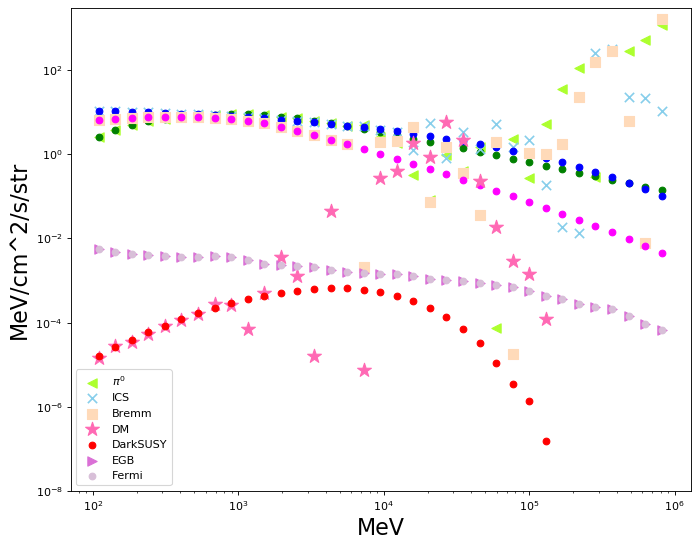

In [27]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]
plt.scatter(cut_energy, piflux*cut_energy**2*norm, label = r'$\pi^0$', color = 'greenyellow', s = sizeofdot, marker = '<')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')

plt.scatter(cut_energy, icsflux*cut_energy**2*norm, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)
plt.scatter(cut_energy, normals[1]/units*cut_energy**2, color = 'blue')

plt.scatter(cut_energy, bremflux*cut_energy**2*norm, label = 'Bremm', color = 'peachpuff', marker = 's', s = sizeofdot)
plt.scatter(cut_energy, normals[2]/units*cut_energy**2, color = 'magenta')



plt.scatter(cut_energy, dmflux*cut_energy**2, label = 'DM', color = 'hotpink', marker = '*', s = sizeofdot+100)
plt.scatter(cut_energy, normals[3]/units*cut_energy**2, color = 'red', label = 'DarkSUSY')


plt.scatter(cut_energy, egbflux*cut_energy**2, label = 'EGB', color = 'orchid', marker = '>', s = sizeofdot)
plt.scatter(cut_energy, normals[4]/units*cut_energy**2, color = 'thistle', label = 'Fermi')

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(0, 1e2)
plt.ylim(1e-8, 3e3)
plt.legend()
#plt.savefig('test_float_dm.pdf')
